In [1]:
import numpy as np
import pandas as pd
import psutil

from collections import defaultdict
#import datatable as dt
import lightgbm as lgb
from matplotlib import pyplot as plt
#import riiideducation
import random
from sklearn.metrics import roc_auc_score
import gc

_ = np.seterr(divide='ignore', invalid='ignore')

In [2]:
#!pip3 install psutil

     |████████████████████████████████| 296 kB 1.4 MB/s eta 0:00:01


In [7]:
#!pip3 install lightgbm

     |████████████████████████████████| 1.8 MB 2.2 MB/s eta 0:00:01


In [4]:
pwd


'/home/kayem/CSE 462 Project'

In [5]:
ls


'Final Project.ipynb'   Project.ipynb   riiid-test-answer-prediction/
 ML_Demo.ipynb          Project.py      riiid-test-answer-prediction.zip


In [6]:
data_types_dict = {
    'timestamp': 'int64',
    'user_id': 'int32', 
    'content_id': 'int16', 
    'content_type_id':'int8', 
    'task_container_id': 'int16',
    'user_answer': 'int8',
    'answered_correctly': 'int8', 
    'prior_question_elapsed_time': 'float32', 
    #'prior_question_had_explanation': 'bool'
}
target = 'answered_correctly'
converters={'prior_question_elapsed_time':lambda x: (x.replace('','1000')),'prior_question_had_explanation':lambda x:(x.replace('NA','False'))}

In [18]:
train_df = pd.read_csv('./riiid-test-answer-prediction/train.csv', dtype=data_types_dict,keep_default_na=True, low_memory=False, nrows=2*10**5)

In [19]:
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [12]:
#train_df['prior_question_elapsed_time']=train_df['prior_question_elapsed_time'].fillna(0)

In [14]:
#train_df['prior_question_had_explanation']=train_df['prior_question_had_explanation'].fillna(False)

In [15]:
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,0.0,False
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [20]:
print(psutil.virtual_memory().percent)

39.4


In [21]:
train_df.dtypes

row_id                              int64
timestamp                           int64
user_id                             int32
content_id                          int16
content_type_id                      int8
task_container_id                   int16
user_answer                          int8
answered_correctly                   int8
prior_question_elapsed_time       float32
prior_question_had_explanation     object
dtype: object

In [22]:
train_df.isnull().sum()

row_id                               0
timestamp                            0
user_id                              0
content_id                           0
content_type_id                      0
task_container_id                    0
user_answer                          0
answered_correctly                   0
prior_question_elapsed_time       4434
prior_question_had_explanation     718
dtype: int64

In [25]:
#reading in lecture df
lectures_df = pd.read_csv('./riiid-test-answer-prediction/lectures.csv')

In [26]:
lectures_df['type_of'] = lectures_df['type_of'].replace('solving question', 'solving_question')

lectures_df = pd.get_dummies(lectures_df, columns=['part', 'type_of'])

part_lectures_columns = [column for column in lectures_df.columns if column.startswith('part')]

types_of_lectures_columns = [column for column in lectures_df.columns if column.startswith('type_of_')]

In [27]:
train_lectures = train_df[train_df.content_type_id == True].merge(lectures_df, left_on='content_id', right_on='lecture_id', how='left')

In [28]:
user_lecture_stats_part = train_lectures.groupby('user_id',as_index = False)[part_lectures_columns + types_of_lectures_columns].sum()

In [29]:
lecturedata_types_dict = {   
    'user_id': 'int32', 
    'part_1': 'int8',
    'part_2': 'int8',
    'part_3': 'int8',
    'part_4': 'int8',
    'part_5': 'int8',
    'part_6': 'int8',
    'part_7': 'int8',
    'type_of_concept': 'int8',
    'type_of_intention': 'int8',
    'type_of_solving_question': 'int8',
    'type_of_starter': 'int8'
}
user_lecture_stats_part = user_lecture_stats_part.astype(lecturedata_types_dict)

In [30]:
for column in user_lecture_stats_part.columns:
    #bool_column = column + '_boolean'
    if(column !='user_id'):
        user_lecture_stats_part[column] = (user_lecture_stats_part[column] > 0).astype('int8')

In [31]:
train_lectures[train_lectures.user_id==5382]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,...,part_2,part_3,part_4,part_5,part_6,part_7,type_of_concept,type_of_intention,type_of_solving_question,type_of_starter
1,117,10183847,5382,16736,1,21,-1,-1,NaN,False,...,0,0,0,0,0,0,1,0,0,0
2,212,1424348597,5382,30207,1,104,-1,-1,NaN,False,...,0,0,0,1,0,0,1,0,0,0
3,216,1425557777,5382,18545,1,121,-1,-1,NaN,False,...,0,0,0,1,0,0,1,0,0,0


In [32]:
user_lecture_stats_part[user_lecture_stats_part.user_id==5382]

,user_id,part_1,part_2,part_3,part_4,part_5,part_6,part_7,type_of_concept,type_of_intention,type_of_solving_question,type_of_starter
1,5382,1,0,0,0,1,0,0,1,0,0,0


In [33]:
user_lecture_stats_part.tail()


,user_id,part_1,part_2,part_3,part_4,part_5,part_6,part_7,type_of_concept,type_of_intention,type_of_solving_question,type_of_starter
282,3924575,0,0,0,0,1,0,0,1,0,0,0
283,3929947,0,1,0,0,0,0,0,1,0,0,0
284,3952154,0,1,0,0,1,0,0,1,0,0,0
285,3972985,1,0,1,1,1,1,1,1,0,1,0
286,4010487,0,1,0,0,0,0,0,1,0,1,0


In [34]:
user_lecture_stats_part.dtypes

user_id                     int32
part_1                       int8
part_2                       int8
part_3                       int8
part_4                       int8
part_5                       int8
part_6                       int8
part_7                       int8
type_of_concept              int8
type_of_intention            int8
type_of_solving_question     int8
type_of_starter              int8
dtype: object

In [35]:
#clearing memory
del(train_lectures)

In [36]:
print(psutil.virtual_memory().percent)

40.4


In [37]:
cum = train_df.groupby('user_id')['content_type_id'].agg(['cumsum', 'cumcount'])
train_df['user_lecture_cumsum'] = cum['cumsum'] 
train_df['user_lecture_lv'] = cum['cumsum'] / cum['cumcount']


train_df.user_lecture_lv=train_df.user_lecture_lv.astype('float16')
train_df.user_lecture_cumsum=train_df.user_lecture_cumsum.astype('int8')
user_lecture_agg = train_df.groupby('user_id')['content_type_id'].agg(['sum', 'count'])

In [38]:
train_df['prior_question_had_explanation'].fillna(False, inplace=True)
train_df = train_df.astype(data_types_dict)
train_df = train_df[train_df[target] != -1].reset_index(drop=True)
prior_question_elapsed_time_mean=train_df['prior_question_elapsed_time'].mean()
train_df['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace=True)

In [39]:
max_timestamp_u = train_df[['user_id','timestamp']].groupby(['user_id']).agg(['max']).reset_index()
#max_timestamp_u = train_df[['user_id','timestamp']].groupby(['user_id']).agg(['max'])
max_timestamp_u.columns = ['user_id', 'max_time_stamp']

In [40]:
train_df['lagtime'] = train_df.groupby('user_id')['timestamp'].shift()
train_df['lagtime']=train_df['timestamp']-train_df['lagtime']
train_df['lagtime'].fillna(0, inplace=True)
train_df.lagtime=train_df.lagtime.astype('int32')
#train_df.drop(columns=['timestamp'], inplace=True)

In [41]:
lagtime_agg = train_df.groupby('user_id')['lagtime'].agg(['mean'])
train_df['lagtime_mean'] = train_df['user_id'].map(lagtime_agg['mean'])
train_df.lagtime_mean=train_df.lagtime_mean.astype('int32')

In [42]:
user_prior_question_elapsed_time = train_df[['user_id','prior_question_elapsed_time']].groupby(['user_id']).tail(1)
#max_timestamp_u = train_df[['user_id','timestamp']].groupby(['user_id']).agg(['max'])
user_prior_question_elapsed_time.columns = ['user_id', 'prior_question_elapsed_time']

In [43]:
train_df['delta_prior_question_elapsed_time'] = train_df.groupby('user_id')['prior_question_elapsed_time'].shift()
train_df['delta_prior_question_elapsed_time']=train_df['prior_question_elapsed_time']-train_df['delta_prior_question_elapsed_time']
train_df['delta_prior_question_elapsed_time'].fillna(0, inplace=True)

In [44]:
train_df.delta_prior_question_elapsed_time=train_df.delta_prior_question_elapsed_time.astype('int32')

In [45]:
train_df['timestamp']=train_df['timestamp']/(1000*3600)
train_df.timestamp=train_df.timestamp.astype('int16')
#

In [46]:
train_df['lag'] = train_df.groupby('user_id')[target].shift()

cum = train_df.groupby('user_id')['lag'].agg(['cumsum', 'cumcount'])
train_df['user_correctness'] = cum['cumsum'] / cum['cumcount']
train_df['user_correct_cumsum'] = cum['cumsum']
train_df['user_correct_cumcount'] = cum['cumcount']
train_df.drop(columns=['lag'], inplace=True)

# train_df['user_correctness'].fillna(1, inplace=True)
train_df['user_correct_cumsum'].fillna(0, inplace=True)
#train_df['user_correct_cumcount'].fillna(0, inplace=True)
train_df.user_correctness=train_df.user_correctness.astype('float16')
train_df.user_correct_cumcount=train_df.user_correct_cumcount.astype('int16')
train_df.user_correct_cumsum=train_df.user_correct_cumsum.astype('int16')

In [47]:
train_df.prior_question_had_explanation=train_df.prior_question_had_explanation.astype('int8')

train_df['lag'] = train_df.groupby('user_id')['prior_question_had_explanation'].shift()

In [48]:
cum = train_df.groupby('user_id')['lag'].agg(['cumsum', 'cumcount'])
train_df['explanation_mean'] = cum['cumsum'] / cum['cumcount']
train_df['explanation_cumsum'] = cum['cumsum'] 
train_df.drop(columns=['lag'], inplace=True)

train_df['explanation_mean'].fillna(0, inplace=True)
train_df['explanation_cumsum'].fillna(0, inplace=True)
train_df.explanation_mean=train_df.explanation_mean.astype('float16')
train_df.explanation_cumsum=train_df.explanation_cumsum.astype('int16')

In [49]:
del cum
gc.collect()

152

In [50]:
train_df["attempt_no"] = 1
train_df.attempt_no=train_df.attempt_no.astype('int8')
train_df["attempt_no"] = train_df[["user_id","content_id",'attempt_no']].groupby(["user_id","content_id"])["attempt_no"].cumsum()

In [51]:
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,...,user_lecture_lv,lagtime,lagtime_mean,delta_prior_question_elapsed_time,user_correctness,user_correct_cumsum,user_correct_cumcount,explanation_mean,explanation_cumsum,attempt_no
0,0,0,115,5692,0,1,3,1,25306.212891,0,...,NaN,0,14523696,0,NaN,0,0,0.0,0,1
1,1,0,115,5716,0,2,2,1,37000.000000,0,...,0.0,56943,14523696,11693,1.0,1,1,0.0,0,1
2,2,0,115,128,0,0,0,1,55000.000000,0,...,0.0,61420,14523696,18000,1.0,2,2,0.0,0,1
3,3,0,115,7860,0,3,0,1,19000.000000,0,...,0.0,12804,14523696,-36000,1.0,3,3,0.0,0,1
4,4,0,115,7922,0,4,1,1,11000.000000,0,...,0.0,6798,14523696,-8000,1.0,4,4,0.0,0,1


In [52]:
train_df.dtypes


row_id                                 int64
timestamp                              int16
user_id                                int32
content_id                             int16
content_type_id                         int8
task_container_id                      int16
user_answer                             int8
answered_correctly                      int8
prior_question_elapsed_time          float32
prior_question_had_explanation          int8
user_lecture_cumsum                     int8
user_lecture_lv                      float16
lagtime                                int32
lagtime_mean                           int32
delta_prior_question_elapsed_time      int32
user_correctness                     float16
user_correct_cumsum                    int16
user_correct_cumcount                  int16
explanation_mean                     float16
explanation_cumsum                     int16
attempt_no                              int8
dtype: object

In [53]:
explanation_agg = train_df.groupby('user_id')['prior_question_had_explanation'].agg(['sum', 'count'])
explanation_agg=explanation_agg.astype('int16')
#train_df.drop(columns=['prior_question_had_explanation'], inplace=True)

In [54]:
user_agg = train_df.groupby('user_id')[target].agg(['sum', 'count'])
content_agg = train_df.groupby('content_id')[target].agg(['sum', 'count','var'])
task_container_agg = train_df.groupby('task_container_id')[target].agg(['sum', 'count','var'])

#prior_question_elapsed_time_agg = train_df.groupby('user_id')['prior_question_elapsed_time'].agg(['sum', 'count'])

In [55]:
user_agg=user_agg.astype('int16')
content_agg=content_agg.astype('float32')
task_container_agg=task_container_agg.astype('float32')

In [56]:
attempt_no_agg=train_df.groupby(["user_id","content_id"])["attempt_no"].agg(['sum'])
attempt_no_agg=attempt_no_agg.astype('int8')
#attempt_series = train_df[['user_id', 'content_id','attempt_no']].groupby(['user_id','content_id'])['attempt_no'].max()

In [57]:
train_df['content_count'] = train_df['content_id'].map(content_agg['count']).astype('int32')
train_df['content_sum'] = train_df['content_id'].map(content_agg['sum']).astype('int32')
train_df['content_correctness'] = train_df['content_id'].map(content_agg['sum'] / content_agg['count'])
train_df.content_correctness=train_df.content_correctness.astype('float16')
train_df['task_container_sum'] = train_df['task_container_id'].map(task_container_agg['sum']).astype('int32')
train_df['task_container_std'] = train_df['task_container_id'].map(task_container_agg['var']).astype('float16')
train_df['task_container_correctness'] = train_df['task_container_id'].map(task_container_agg['sum'] / task_container_agg['count'])
train_df.task_container_correctness=train_df.task_container_correctness.astype('float16')

In [59]:
questions_df = pd.read_csv(
    './riiid-test-answer-prediction/questions.csv', 
    usecols=[0, 1,3,4],
    dtype={'question_id': 'int16','bundle_id': 'int16', 'part': 'int8','tags': 'str'}
)
questions_df['part_bundle_id']=questions_df['part']*100000+questions_df['bundle_id']
questions_df.part_bundle_id=questions_df.part_bundle_id.astype('int32')
tag = questions_df["tags"].str.split(" ", n = 10, expand = True)
tag.columns = ['tags1','tags2','tags3','tags4','tags5','tags6']
#

tag.fillna(0, inplace=True)
tag = tag.astype('int16')
questions_df =  pd.concat([questions_df,tag],axis=1).drop(['tags'],axis=1)

In [60]:
questions_df.rename(columns={'question_id':'content_id'}, inplace=True)

In [61]:
questions_df['content_correctness'] = questions_df['content_id'].map(content_agg['sum'] / content_agg['count'])
questions_df.content_correctness=questions_df.content_correctness.astype('float16')
questions_df['content_correctness_std'] = questions_df['content_id'].map(content_agg['var'])
questions_df.content_correctness_std=questions_df.content_correctness_std.astype('float16')

In [62]:
part_agg = questions_df.groupby('part')['content_correctness'].agg(['mean', 'var'])
questions_df['part_correctness_mean'] = questions_df['part'].map(part_agg['mean'])
questions_df['part_correctness_std'] = questions_df['part'].map(part_agg['var'])
questions_df.part_correctness_mean=questions_df.part_correctness_mean.astype('float16')
questions_df.part_correctness_std=questions_df.part_correctness_std.astype('float16')

In [63]:
bundle_agg = questions_df.groupby('bundle_id')['content_correctness'].agg(['mean'])
questions_df['bundle_correctness'] = questions_df['bundle_id'].map(bundle_agg['mean'])
questions_df.bundle_correctness=questions_df.bundle_correctness.astype('float16')

In [64]:
tags1_agg = questions_df.groupby('tags1')['content_correctness'].agg(['mean', 'var'])
questions_df['tags1_correctness_mean'] = questions_df['tags1'].map(tags1_agg['mean'])
questions_df['tags1_correctness_std'] = questions_df['tags1'].map(tags1_agg['var'])
questions_df.tags1_correctness_mean=questions_df.tags1_correctness_mean.astype('float16')
questions_df.tags1_correctness_std=questions_df.tags1_correctness_std.astype('float16')

In [65]:
questions_df.drop(columns=['content_correctness'], inplace=True)

In [66]:
questions_df.dtypes

content_id                   int16
bundle_id                    int16
part                          int8
part_bundle_id               int32
tags1                        int16
tags2                        int16
tags3                        int16
tags4                        int16
tags5                        int16
tags6                        int16
content_correctness_std    float16
part_correctness_mean      float16
part_correctness_std       float16
bundle_correctness         float16
tags1_correctness_mean     float16
tags1_correctness_std      float16
dtype: object

In [67]:
del bundle_agg
del part_agg
del tags1_agg
gc.collect()

217

In [68]:
len(train_df)

196284

In [69]:
train_df['user_correctness'].fillna( 1, inplace=True)
train_df['attempt_no'].fillna(1, inplace=True)
#
train_df.fillna(0, inplace=True)

In [70]:
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,...,user_correct_cumcount,explanation_mean,explanation_cumsum,attempt_no,content_count,content_sum,content_correctness,task_container_sum,task_container_std,task_container_correctness
0,0,0,115,5692,0,1,3,1,25306.212891,0,...,0,0.0,0,1,71,52,0.732422,373,0.250000,0.517578
1,1,0,115,5716,0,2,2,1,37000.000000,0,...,1,0.0,0,1,50,39,0.779785,310,0.245483,0.430664
2,2,0,115,128,0,0,0,1,55000.000000,0,...,2,0.0,0,1,38,37,0.973633,496,0.215332,0.687012
3,3,0,115,7860,0,3,0,1,19000.000000,0,...,3,0.0,0,1,41,40,0.975586,385,0.249146,0.534180
4,4,0,115,7922,0,4,1,1,11000.000000,0,...,4,0.0,0,1,34,34,1.000000,612,0.250000,0.490723


In [71]:
train_df.dtypes

row_id                                 int64
timestamp                              int16
user_id                                int32
content_id                             int16
content_type_id                         int8
task_container_id                      int16
user_answer                             int8
answered_correctly                      int8
prior_question_elapsed_time          float32
prior_question_had_explanation          int8
user_lecture_cumsum                     int8
user_lecture_lv                      float16
lagtime                                int32
lagtime_mean                           int32
delta_prior_question_elapsed_time      int32
user_correctness                     float16
user_correct_cumsum                    int16
user_correct_cumcount                  int16
explanation_mean                     float16
explanation_cumsum                     int16
attempt_no                              int8
content_count                          int32
content_su

In [72]:
#HDKIM 

MAX_SEQ = 160

skills = train_df["content_id"].unique()
n_skill = len(skills)
print("number skills", len(skills))

group = train_df[['user_id', 'content_id', 'answered_correctly']].groupby('user_id').apply(lambda r: (
            r['content_id'].values,
            r['answered_correctly'].values))

for user_id in group.index:
    q, qa = group[user_id]
    if len(q)>MAX_SEQ:
        group[user_id] = (q[-MAX_SEQ:],qa[-MAX_SEQ:])
        
import pickle
pickle.dump(group, open("group.pkl", "wb"))
del group
gc.collect()

#HDKIMHDKIM

number skills 12438


0

In [73]:
features = [
#   'user_id',
#HDKIM    'timestamp',
    'lagtime',
    'lagtime_mean',
   # 'content_id',
   # 'task_container_id',
    'user_lecture_cumsum', # X
    'user_lecture_lv',
    'prior_question_elapsed_time',
    'delta_prior_question_elapsed_time',
    'user_correctness',
    'user_correct_cumcount', #X
    'user_correct_cumsum', #X
    'content_correctness',
   # 'content_correctness_std',
    'content_count',
    'content_sum', #X
    'task_container_correctness',
   # 'task_container_std',
   # 'task_container_sum',
    'bundle_correctness',
    'attempt_no',
    'part',
    'part_correctness_mean',
   # 'part_correctness_std',
    'tags1',
    'tags1_correctness_mean',
  #  'tags1_correctness_std',
#HDKIM    'tags2',
#HDKIM    'tags3',
#HDKIM    'tags4',
#HDKIM    'tags5',
#HDKIM    'tags6',
    'bundle_id',
  #  'part_bundle_id',
    'explanation_mean', 
    'explanation_cumsum',
    'prior_question_had_explanation',
#     'part_1',
#     'part_2',
#     'part_3',
#     'part_4',
#     'part_5',
#     'part_6',
#     'part_7',
#     'type_of_concept',
#     'type_of_intention',
#     'type_of_solving_question',
#     'type_of_starter'
]
categorical_columns= [
#   'user_id',
  #  'content_id',
  # 'task_container_id',
    'part',        
    'tags1',
#HDKIM    'tags2',
#HDKIM    'tags3',
#HDKIM    'tags4',
#HDKIM    'tags5',
#HDKIM    'tags6',
    'bundle_id',
   # 'part_bundle_id',
    'prior_question_had_explanation',
#     'part_1',
#     'part_2',
#     'part_3',
#     'part_4',
#     'part_5',
#     'part_6',
#     'part_7',
#     'type_of_concept',
#     'type_of_intention',
#     'type_of_solving_question',
#     'type_of_starter'
]


In [75]:
flag_lgbm=True
clfs = list()
params = {
'num_leaves': 350,
'max_bin':700,
'min_child_weight': 0.03454472573214212,
'feature_fraction': 0.58,
'bagging_fraction': 0.58,
#'min_data_in_leaf': 106,
'objective': 'binary',
'max_depth': -1,
'learning_rate': 0.05,
"boosting_type": "gbdt",
"bagging_seed": 11,
"metric": 'auc',
"verbosity": -1,
'reg_alpha': 0.3899927210061127,
'reg_lambda': 0.6485237330340494,
'random_state': 47
}
trains=list()
valids=list()
num=1
for i in range(0,num):
  
    #train_df=train_df.reset_index(drop=True)
    train_df_clf=train_df.sample(n=50000)
    print('sample end')
    #train_df.drop(train_df_clf.index, inplace=True)
    #print('train_df drop end')
    
   
    del train_df
    
    users=train_df_clf['user_id'].drop_duplicates()#去重
    
    users=users.sample(frac=0.025)
    users_df=pd.DataFrame()
    users_df['user_id']=users.values
  
  
    valid_df_newuser = pd.merge(train_df_clf, users_df, on=['user_id'], how='inner',right_index=True)
    del users_df
    del users
    gc.collect()
    #
    train_df_clf.drop(valid_df_newuser.index, inplace=True)
   
    #-----------
    #train_df_clf=train_df_clf.sample(frac=0.2)
    #train_df_clf.drop(valid_df_newuser.index, inplace=True)
    train_df_clf = pd.merge(train_df_clf, questions_df, on='content_id', how='left',right_index=True)#
    valid_df_newuser = pd.merge(valid_df_newuser, questions_df, on='content_id', how='left',right_index=True)#
    
#     train_df_clf = pd.merge(train_df_clf, user_lecture_stats_part, on='user_id', how="left",right_index=True)
#     valid_df_newuser = pd.merge(valid_df_newuser, user_lecture_stats_part, on='user_id', how="left",right_index=True)

    valid_df=train_df_clf.sample(frac=0.09)
    train_df_clf.drop(valid_df.index, inplace=True)
   
    valid_df = valid_df.append(valid_df_newuser)
    del valid_df_newuser
    gc.collect()
    #

    trains.append(train_df_clf)
    valids.append(valid_df)
    print('valid_df length：',len(valid_df))
    #train_df=train_df.reset_index(drop=True)

sample end
valid_df length： 5208


In [76]:
#del train_df
del train_df_clf
del valid_df
gc.collect()

20

/home/kayem/.local/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['bundle_id', 'part', 'prior_question_had_explanation', 'tags1']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
/home/kayem/.local/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/kayem/.local/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.924887	valid_1's auc: 0.789552
[100]	training's auc: 0.967706	valid_1's auc: 0.789064
Early stopping, best iteration is:
[60]	training's auc: 0.935233	valid_1's auc: 0.790483


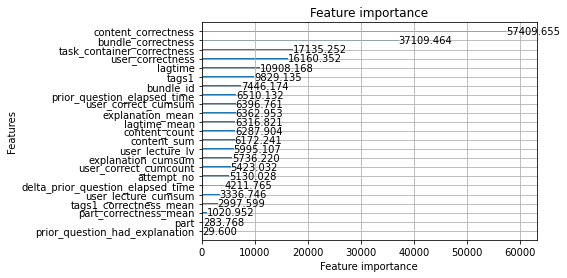

In [77]:
for i in range(0,num):

#     
    tr_data = lgb.Dataset(trains[i][features], label=trains[i][target])
    va_data = lgb.Dataset(valids[i][features], label=valids[i][target])
    
#     del train_df_clf
#     del valid_df
#     gc.collect()
    del trains
    del valids
    gc.collect()

    model = lgb.train(
        params, 
        tr_data,
#         train_df[features],
#         train_df[target],
        num_boost_round=5000,
        #valid_sets=[(train_df[features],train_df[target]), (valid_df[features],valid_df[target])], 
        valid_sets=[tr_data, va_data],
        early_stopping_rounds=50,
        feature_name=features,
        categorical_feature=categorical_columns,
        verbose_eval=50
    )
    clfs.append(model)
    #print('auc:', roc_auc_score(valid_df[target], model.predict(valid_df[features])))
    #model.save_model(f'model.txt')
    lgb.plot_importance(model, importance_type='gain')
    plt.show()

    del tr_data
    del va_data
    gc.collect()
#    
# del trains
# del valids
# gc.collect()